OLS Regression Results:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     414.2
Date:                Wed, 16 Apr 2025   Prob (F-statistic):           3.08e-48
Time:                        13:07:22   Log-Likelihood:                -90.869
No. Observations:                 100   AIC:                             187.7
Df Residuals:                      97   BIC:                             195.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9330      0

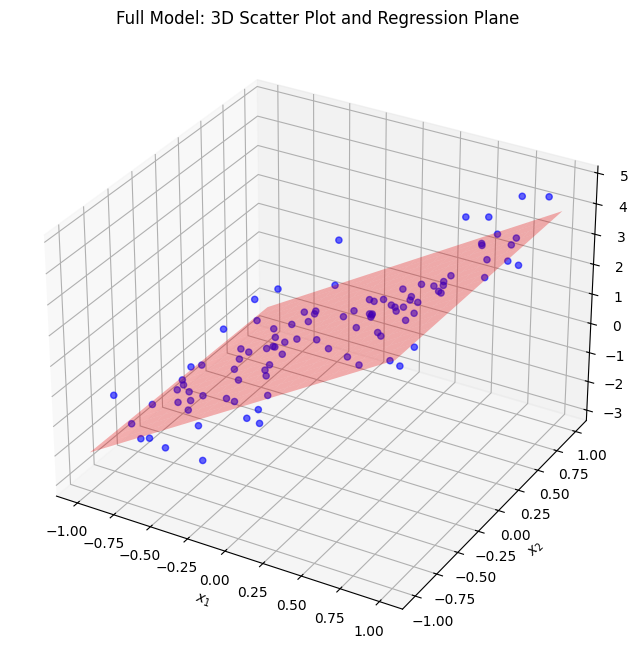

********************************

Reduced Model OLS Regression Results (using only x1):
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     835.3
Date:                Wed, 16 Apr 2025   Prob (F-statistic):           9.27e-50
Time:                        13:07:24   Log-Likelihood:                -90.960
No. Observations:                 100   AIC:                             185.9
Df Residuals:                      98   BIC:                             191.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

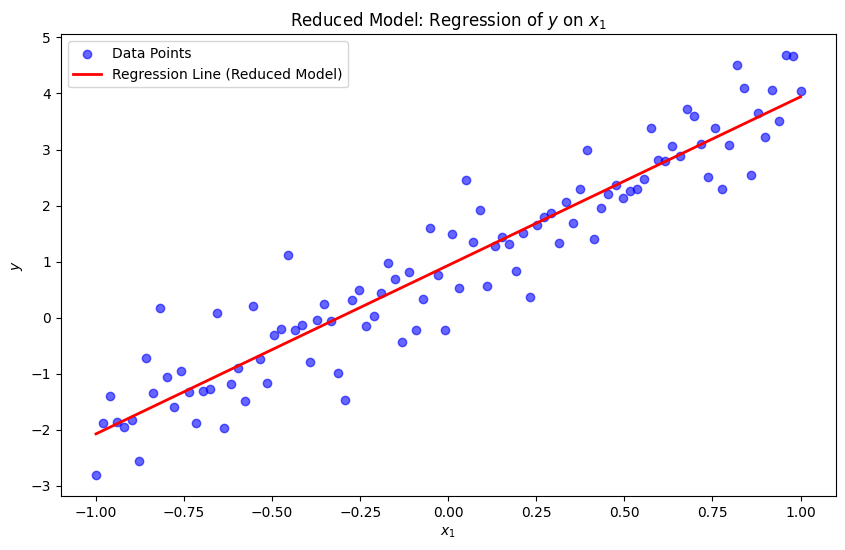

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score

# -----------------------------
# 1. DATA GENERATION
# -----------------------------
np.random.seed(42)
n = 100

# Generate x1 as n evenly spaced points in [-1,1]
x1 = np.linspace(-1, 1, n)

# To avoid perfect collinearity, generate x2 as a permutation of linspace values.
x2 = np.random.permutation(np.linspace(-1, 1, n))

# For each observation, sample a random multiplier from Uniform(-1, 1)
rand_multiplier = np.random.uniform(-1, 1, n)

# Compute y using the model: y = 3*x1 + 2*(rand_multiplier)*x2 + 1
y = 3 * x1 + 2 * rand_multiplier * x2 + 1

# Put the data into a DataFrame
data = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})

# ********************************
# 2. OLS Regression and t-tests
# ********************************
X = data[['x1', 'x2']]
X_const = sm.add_constant(X)
ols_model = sm.OLS(data['y'], X_const)
ols_results = ols_model.fit()
print("OLS Regression Results:")
print(ols_results.summary())

print("********************************")

# ********************************
# 3. Standardized Coefficients
# ********************************
# Standardize the predictors so that coefficients are on the same scale
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std_const = sm.add_constant(X_std)
ols_std_model = sm.OLS(data['y'], X_std_const)
ols_std_results = ols_std_model.fit()
print("\nStandardized Coefficients:")
print(ols_std_results.params)

print("********************************")

# ********************************
# 4. Partial R-Squared
# ********************************
# Full model R^2:
R2_full = ols_results.rsquared

# Reduced model dropping x1 (i.e. using only x2)
X2_const = sm.add_constant(data[['x2']])
ols_model_x2 = sm.OLS(data['y'], X2_const).fit()
R2_x2 = ols_model_x2.rsquared

# Reduced model dropping x2 (i.e. using only x1)
X1_const = sm.add_constant(data[['x1']])
ols_model_x1 = sm.OLS(data['y'], X1_const).fit()
R2_x1 = ols_model_x1.rsquared

# Compute partial R^2 (the unique contribution of a variable)
partial_R2_x1 = (R2_full - R2_x2) / (1 - R2_full)
partial_R2_x2 = (R2_full - R2_x1) / (1 - R2_full)
print("\nPartial R^2 for x1:", partial_R2_x1)
print("Partial R^2 for x2:", partial_R2_x2)

print("********************************")

# ********************************
# 5. LASSO Regression (Variable Selection)
# ********************************
# LASSO is sensitive to scaling; we already have standardized predictors in X_std.
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_std, y)
print("\nLASSO Regression Results (using standardized predictors):")
print("Intercept:", lasso.intercept_)
print("Coefficients:", lasso.coef_)

# --- Remark on LASSO Coefficients ---
print("\nInterpretation of LASSO Coefficients: The magnitude of LASSO coefficients depends on the regularization strength (alpha chosen by LassoCV). While relative magnitudes can be informative, the absolute values might not directly correspond to the OLS coefficients.")

print("********************************")

# ********************************
# 6. Recursive Feature Elimination (RFE)
# ********************************
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=1)
selector.fit(X, y)
ranking = pd.DataFrame({'Variable': X.columns, 'Ranking': selector.ranking_})
print("\nRFE Feature Ranking (1 = most important):")
print(ranking)

# --- Remark on RFE ---
print("\nRFE with LinearRegression: While LinearRegression is used in RFE here, other estimators could be used depending on the goal (e.g., a more robust estimator).")

print("********************************")

# ********************************
# 7. Permutation Importance
# ********************************
model_lr = LinearRegression()
model_lr.fit(X, y)
perm_importance = permutation_importance(model_lr, X, y, scoring='r2', n_repeats=30, random_state=42)
perm_df = pd.DataFrame({'Variable': X.columns, 'Importance Mean': perm_importance.importances_mean})
print("\nPermutation Importance (based on decrease in R^2):")
print(perm_df)

# --- Remark on Permutation Importance ---
print("\nRandomness in Permutation Importance: Permutation importance involves random shuffling, so running it multiple times (as done with n_repeats) and looking at the mean importance provides a more stable estimate.")

print("********************************")

# ********************************
# 8. Visualization of Full Model (3D Plot)
# ********************************
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the original data points
ax.scatter(data['x1'], data['x2'], data['y'], color='blue', alpha=0.6, label='Data Points')

# Create a grid to plot the regression plane
x1_range = np.linspace(data['x1'].min(), data['x1'].max(), 20)
x2_range = np.linspace(data['x2'].min(), data['x2'].max(), 20)
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)

# Extract coefficients for the regression plane
const_full = ols_results.params['const']
coef_x1 = ols_results.params['x1']
coef_x2 = ols_results.params['x2']
y_pred_grid = const_full + coef_x1 * x1_grid + coef_x2 * x2_grid

# Plot the regression plane
ax.plot_surface(x1_grid, x2_grid, y_pred_grid, color='red', alpha=0.3)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$y$')
ax.set_title('Full Model: 3D Scatter Plot and Regression Plane')

plt.show()

print("********************************")

# ********************************
# 9. Reduced Model: y = m*x1 + c
# ********************************
# Fit the reduced model using only x1
X_reduced = data[['x1']]
X_reduced_const = sm.add_constant(X_reduced)
ols_reduced_model = sm.OLS(data['y'], X_reduced_const)
ols_reduced_results = ols_reduced_model.fit()
print("\nReduced Model OLS Regression Results (using only x1):")
print(ols_reduced_results.summary())

print("********************************")

# ********************************
# 10. Visualization of Reduced Model (2D Plot)
# ********************************
plt.figure(figsize=(10, 6))
plt.scatter(data['x1'], data['y'], color='blue', alpha=0.6, label='Data Points')

x1_line = np.linspace(data['x1'].min(), data['x1'].max(), 100)
y_line = ols_reduced_results.params['const'] + ols_reduced_results.params['x1'] * x1_line
plt.plot(x1_line, y_line, color='red', linewidth=2, label='Regression Line (Reduced Model)')

plt.xlabel(r'$x_1$')
plt.ylabel(r'$y$')
plt.title('Reduced Model: Regression of $y$ on $x_1$')
plt.legend()
plt.show()